

# Classification-Which IPO to purchase?

Instead of attempting to predict exactly what the total first day return will be, we are going to attempt to predict if the IPO will be one we should buy for a trade or not.

The dataset used is the https://www.iposcoop.com/scoop-track-record-from-2000-to-present/. 

Focus of this case study are:
* Feature Engineering and feature selection
* Build trading strategy using classification (Classification of long/short signals)
* Data Discretization- Handling categorical Data
* Data Exploration and visualisation 


## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1.Feature Engineering and Data Preparation](#3.1)
    * [4.2.Preparing the data for classification](#3.2)
    * [4.3.Feature Selection](#3.3)   
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)  
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Backtesting](#6.3)


<a id='0'></a>
# 1. Introduction

The dataset used is the https://www.iposcoop.com/scoop-track-record-from-2000-to-present/. The dataset has columns related to the IPO which are Trade Date, Issuer, Joint Lead Managers, Offer Price, Opening Price, Close Price, 1st Day percentage Px Chng, $Change Opening, $ Change Close and Star Ratings. 

The predicted variable is **First day Open to Close percentage change**. In case the First day Open to Close percentage change is good (i.e. > 2.5%), then the performance of the IPO is considered good and is flagged as 1 otherwise it is considered to be 0. 
The predicted variables is forecasted as a function of other variables, and a trading strategy is decided accordingly. 

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [81]:
# Load libraries
import numpy as np
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

<a id='1.2'></a>
## 2.2. Loading the Data

In [82]:
wb = xlrd.open_workbook('SCOOP-Rating-Performance.xls')

In [83]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [84]:
ws = wb.sheet_by_index(0)
ws.nrows

3478

<a id='2'></a>
# 3. Exploratory Data Analysis


<a id='2.1'></a>
## 3.1 Descriptive Statistics


Combining the data fromt the spreadsheet and creating a dataframe

In [85]:
ipo_list = []
for i in range(36,ws.nrows):
    if isinstance(ws.row(i)[0].value, float):
        ipo_list.append([x.value for x in ws.row(i)])        
dataset = pd.DataFrame(ipo_list)        

Assigning the column names to the data

In [86]:
dataset.columns = ['Date', 'Company', 'Ticker', 'Managers', \
              'Offer Price', 'Opening Price', '1st Day Close',\
              '1st Day % Chg', '$ Chg Open', '$ Chg Close',\
              'Star Rating', 'Performed']
dataset.head()

,Date,Company,Ticker,Managers,Offer Price,Opening Price,1st Day Close,1st Day % Chg,$ Chg Open,$ Chg Close,Star Rating,Performed
0,43473.0,MMTEC,MTC,WestPark Capital,4.0,5.91,7.55,0.8875,1.91,3.55,N/C,
1,43494.0,Andina Acquisition Corp. III,ANDAU,Cowen/ Craig-Hallum Capital Group,10.0,10.00,10.01,0.001,0.00,0.01,1,
2,43495.0,PIMCO Energy & Tactical Credit Opportunities Fund,NRGX,UBS Investment Bank/ BofA Merrill Lynch/ Morga...,20.0,20.00,20.20,0.01,0.00,0.20,1,
3,43496.0,New Fortress Energy,NFE,Morgan Stanley/ Barclays,14.0,13.25,13.07,-0.0664286,-0.75,-0.93,1,
4,43496.0,Pivotal Acquisition,PVT.U,Cantor,10.0,10.05,10.10,0.01,0.05,0.10,1,


Adding the dates in the right format

In [87]:
def to_date(x):
    return xlrd.xldate.xldate_as_datetime(x, wb.datemode)

In [88]:
dataset['Date'] = dataset['Date'].apply(to_date)
dataset['Year'], dataset['Month'], dataset['Day'], dataset['Day of Week'] = \
dataset['Date'].dt.year, dataset['Date'].dt.month, dataset['Date'].dt.day, dataset['Date'].dt.weekday

In [89]:
dataset.describe()

,Offer Price,Opening Price,1st Day Close,$ Chg Open,$ Chg Close,Year,Month,Day,Day of Week
count,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000
mean,14.505524,16.535642,16.796206,2.031953,2.295201,2009.776182,6.909336,15.936565,2.578396
std,6.402908,9.206517,9.762947,4.531645,5.461207,5.754963,3.240418,8.467777,1.134077
min,0.000000,0.650000,0.650000,-6.850000,-6.340000,2000.000000,1.000000,1.000000,0.000000
25%,10.000000,10.060000,10.062500,0.000000,0.000000,2005.000000,4.000000,9.000000,2.000000
50%,14.000000,15.000000,15.000000,0.500000,0.500000,2010.000000,7.000000,16.000000,3.000000
75%,18.000000,20.157500,20.550000,2.500000,2.965000,2014.000000,10.000000,23.000000,3.000000
max,91.000000,120.000000,132.990000,65.000000,95.540000,2019.000000,12.000000,31.000000,6.000000


In [90]:
dataset.dtypes

Date             datetime64[ns]
Company                  object
Ticker                   object
Managers                 object
Offer Price             float64
Opening Price           float64
1st Day Close           float64
1st Day % Chg            object
$ Chg Open              float64
$ Chg Close             float64
Star Rating              object
Performed                object
Year                      int64
Month                     int64
Day                       int64
Day of Week               int64
dtype: object

In [91]:
dataset['Star Rating'].unique()

array(['N/C', 1.0, 2.0, 3.0, 4.0, 5.0], dtype=object)

In [92]:
dataset['Performed'].unique()

array(['', 'Missed', 'No Call'], dtype=object)

<a id='2.2'></a>
## 3.2. Data Visualization

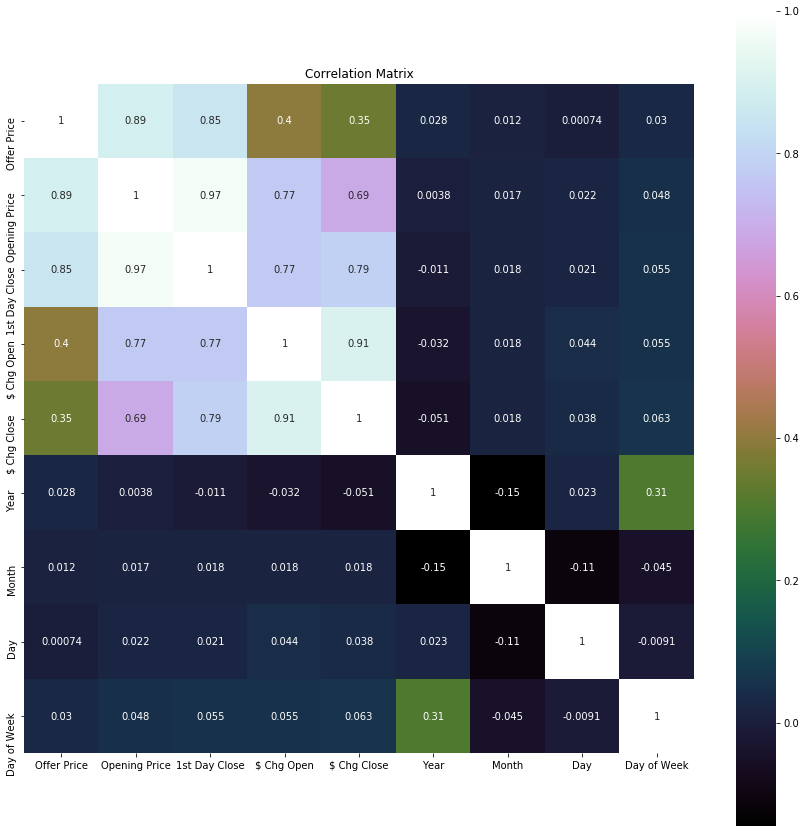

In [93]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

IPO Count by Year

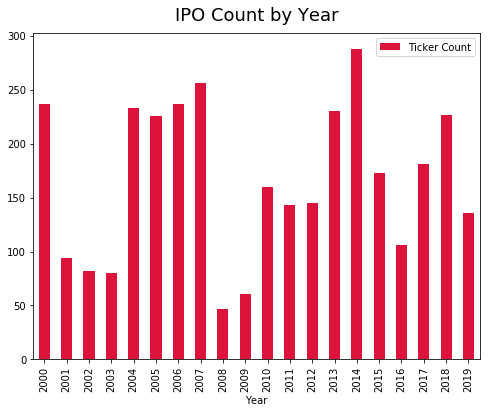

In [94]:
by_year_cnt = dataset.groupby('Year')[['Ticker']].count()
fig, ax = plt.subplots(figsize=(8,6))
by_year_cnt.plot(kind='bar', ax=ax, color='crimson')
ax.legend(['Ticker Count'])
ax.set_title('IPO Count by Year', fontdict={'size': 18}, y=1.02);

In [95]:
#Cleaning the dataset and setting the datatype of the 1st day change to float
dataset[dataset['Offer Price'] < 5].index
dataset.drop(dataset[dataset['Offer Price'] < 5].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset['1st Day % Chg'] = dataset['1st Day % Chg'].astype(float)

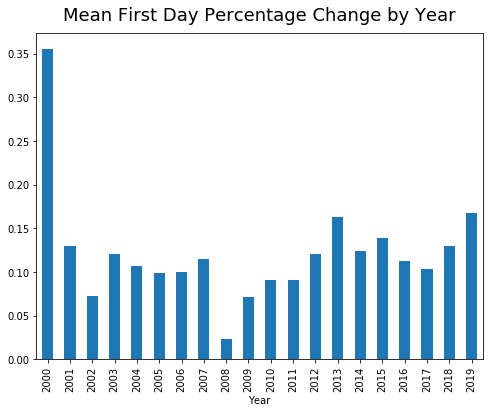

In [96]:
summary_by_year = dataset.groupby('Year')['1st Day % Chg'].describe()
fig, ax = plt.subplots(figsize=(8,6))
summary_by_year['mean'].plot(kind='bar', ax=ax)
ax.set_title('Mean First Day Percentage Change by Year', fontdict={'size': 18}, y=1.02);

<a id='3'></a>
# 4. Feature Engineering and Data Preparation

<a id='3.1'></a>
## 4.1. Feature Engineering- Creating new variables

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

In [97]:
dataset['1st Day Open to Close % Chg'] = ((dataset['1st Day Close'] - dataset['Opening Price'])/dataset['Opening Price'])

In [98]:
dataset['1st Day Open to Close $ Chg'] = (dataset['1st Day Close'] - dataset['Opening Price'])

In [99]:
dataset['Opening Gap % Chg'] = (dataset['Opening Price'] - dataset['Offer Price'])/dataset['Offer Price']

In [100]:
dataset['Opening Gap $ Chg'] = (dataset['Opening Price'] - dataset['Offer Price'])

In [101]:
def get_mgr_count(x):
    return len(x.split('/'))

In [102]:
dataset['Mgr Count'] = dataset['Managers'].apply(get_mgr_count)

In [103]:
dataset['Lead Mgr'] = dataset['Managers'].apply(lambda x: x.split('/')[0])

<a id='3.2'></a>
## 4.2. Preparing the data for classification

In [104]:
from patsy import dmatrix

In [105]:
Y = dataset['1st Day Open to Close % Chg'].apply(lambda x: 1 if x > .025 else 0)

In [106]:
X = dmatrix("Q('Opening Gap % Chg') + C(Q('Month'), Treatment) + C(Q('Day of Week'), Treatment)\
+ Q('Mgr Count') + Q('Lead Mgr') + Q('Offer Price') + C(Q('Star Rating'), Treatment)", dataset, return_type="dataframe")

In [107]:
X.head()

,Intercept,"C(Q('Month'), Treatment)[T.2]","C(Q('Month'), Treatment)[T.3]","C(Q('Month'), Treatment)[T.4]","C(Q('Month'), Treatment)[T.5]","C(Q('Month'), Treatment)[T.6]","C(Q('Month'), Treatment)[T.7]","C(Q('Month'), Treatment)[T.8]","C(Q('Month'), Treatment)[T.9]","C(Q('Month'), Treatment)[T.10]",...,Q('Lead Mgr')[T.​Credit Suisse],Q('Lead Mgr')[T.​Jefferies],"C(Q('Star Rating'), Treatment)[T.2.0]","C(Q('Star Rating'), Treatment)[T.3.0]","C(Q('Star Rating'), Treatment)[T.4.0]","C(Q('Star Rating'), Treatment)[T.5.0]","C(Q('Star Rating'), Treatment)[T.N/C]",Q('Opening Gap % Chg'),Q('Mgr Count'),Q('Offer Price')
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,10.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.0,20.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.053571,2.0,14.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005000,1.0,10.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014000,3.0,10.0


We can see that Patsy has reconfigured our categorical data into multiple columns while keeping our continuous data in a single column. This is called dummy coding. In this format, each month except one will get its own column. The same is true for each broker. For example, if the particular IPO instance (row) was in May, then May will have 1 in the May column while all the other month columns are 0 for this row. There are always n-1 feature columns for each categorical feature. The one that is excluded becomes the baseline that the others are compared against.

Finally, Patsy also adds an intercept column. This is a column of 1s that is needed for regression models to function properly.

<a id='3.3'></a>
## 4.3. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [108]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values drop the rown contianing the null values.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [109]:
# split out validation dataset for the end
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
validation_size = 0.4
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(StandardisedX, Y, test_size=validation_size, random_state=seed)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


As it can be seem from the numbers above Credit Amount is the most important feature followed by duration.

In [110]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring = 'recall'
#scoring = 'precision'
#scoring ='neg_log_loss'
scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1. Common Models

In [111]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

### K-folds cross validation

In [112]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.591384 (0.037379)
LDA: 0.579942 (0.047953)
KNN: 0.556307 (0.032865)
CART: 0.508923 (0.036439)
NB: 0.507340 (0.014633)
SVM: 0.552194 (0.039060)
NN: 0.572629 (0.025395)
AB: 0.643856 (0.027125)
GBM: 0.657710 (0.032858)
RF: 0.615107 (0.034828)
ET: 0.583227 (0.031793)


In [113]:
# prepare model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
#model = LogisticRegression() # rbf is default kernel
#model = GaussianNB() # rbf is default kernel
model = RandomForestClassifier(criterion = 'gini', max_depth = 200, n_estimators =  80)

model = GradientBoostingClassifier(n_estimators=20, max_depth=3) # rbf is default kernel
model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [114]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6870286576168929
[[907   7]
 [408   4]]
              precision    recall  f1-score   support

           0       0.69      0.99      0.81       914
           1       0.36      0.01      0.02       412

    accuracy                           0.69      1326
   macro avg       0.53      0.50      0.42      1326
weighted avg       0.59      0.69      0.57      1326



### Algorithm comparison

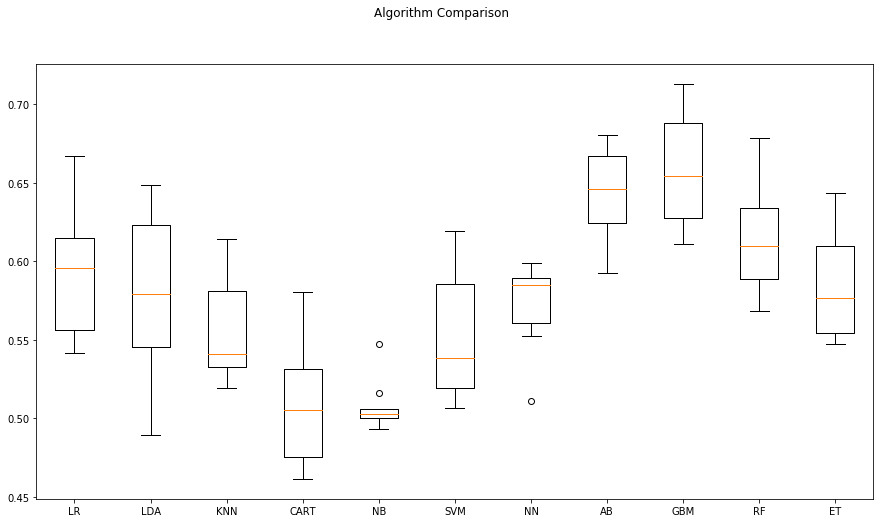

In [115]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Algorithm Tuning: Although some of the models show the most promising options. the grid search for Gradient Bossting Classifier is shown below.

In [125]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.669078 using {'max_depth': 3, 'n_estimators': 20}
#1 0.669078 (0.032247) with: {'max_depth': 3, 'n_estimators': 20}
#2 0.652676 (0.031699) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.648421 (0.024101) with: {'max_depth': 5, 'n_estimators': 20}
#4 0.642973 (0.021552) with: {'max_depth': 5, 'n_estimators': 180}


<a id='6'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [126]:
# prepare model
model = GradientBoostingClassifier(n_estimators=20, max_depth=5) # rbf is default kernel
model.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [127]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6855203619909502
[[884  30]
 [387  25]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       914
           1       0.45      0.06      0.11       412

    accuracy                           0.69      1326
   macro avg       0.58      0.51      0.46      1326
weighted avg       0.62      0.69      0.59      1326



<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.Let us look into the Feature Importance of the GBM model. 

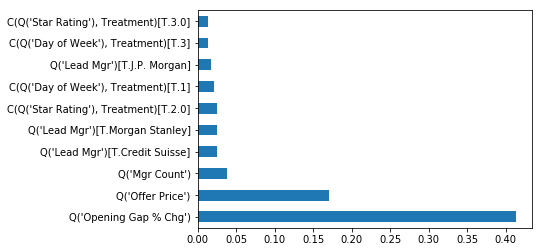

In [128]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The output from this gives us a ranked list of feature importance along with error bars for each. Looking at the list, these rankings would seem to make sense with gap opening percentage and dollar change from opening leading the pack.

<a id='6.3'></a>
## 7.3. Backtesting

Bactesting to Check how much money can be gained or lost from the strategy.

In [129]:
pdf = pd.DataFrame({'Actual': Y_validation, 'predicted': predictions})

pdf['correct'] = pdf.apply(lambda x: 1 if x['Actual'] == x['predicted'] else 0, axis=1)

results = pd.merge(dataset[['1st Day Open to Close $ Chg']], pdf, left_index=True, right_index=True)

In [130]:
# ipo buys
results[results['predicted']==1]['1st Day Open to Close $ Chg'].count()

# ipo buys that made money 
Profit = results[(results['Actual']==1)&(results['predicted']==1)]['1st Day Open to Close $ Chg'].sum()
Profit

82.89625

In [131]:
# ipo buys that lost money
Loss= results[(results['Actual']==0)&(results['predicted']==1)]['1st Day Open to Close $ Chg'].sum()
Loss

-27.775000000000002

In [132]:
#Total Profit
NetProfit = Profit + Loss
NetProfit

55.12124999999999

So, looking at the output the strategy is profitable overall. Also, looking at the opportunity that was not explored

In [133]:
# ipos not bought that would have made money
ProfitLost= results[(results['Actual']==1)&(results['predicted']==0)]['1st Day Open to Close $ Chg'].sum()

# ipos not bought that would have lost money
LossAvoided= results[(results['Actual']==0)&(results['predicted']==0)]['1st Day Open to Close $ Chg'].sum()
TotalProfitMissed=ProfitLost+LossAvoided
TotalProfitMissed

331.024875

## Conclusion


- Consideration of these factors is shown to impact the IPO market

* Looking at the backtesting results, the overall strategy is profitable. 
* Feature Engineering leads to creation of new catergorical and intuitive features and increases the predictive power by creating features from raw data that help facilitate the modeling process. 
* The charts and data visualisation provide an intuition into the IPO market and price movement. 


